In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, \
                                    Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, \
                        Activation, LeakyReLU, UpSampling2D, \
                                    Conv2D

In [3]:
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

In [7]:
# 모델 이름을 generator로 정하고 Sequential() 함수를 호출
generator = Sequential()

generator.add(Dense(128*7*7, input_dim=100, \
                   activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', \
                    activation='tanh'))

In [8]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)       

In [12]:
# 판멸자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, \
                        input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, \
                        padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', \
                     optimizer='adam')
discriminator.trainable = False

In [13]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [22]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32')
    X_train = (X_train - 127.5) / 127.5 #절반을 빼고, 그 절반으로 나누면 -1~1사이의 range로 변환됨
    
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real=discriminator.train_on_batch(imgs, true)
        
        #train_on_batch로 학습 (input, target)
        noise = np.random.normal(0,1,(batch_size,100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs,fake)
        
        #판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise,true)

        print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' %g_loss)
        
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)
              
                # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5
              fig, axs = plt.subplots(5, 5)
              count = 0
              
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

epoch:0 d_loss:0.7286 g_loss:0.5138
epoch:1 d_loss:0.5294 g_loss:0.2460
epoch:2 d_loss:0.5397 g_loss:0.1080
epoch:3 d_loss:0.5638 g_loss:0.1070
epoch:4 d_loss:0.5348 g_loss:0.1984
epoch:5 d_loss:0.4733 g_loss:0.3736
epoch:6 d_loss:0.4508 g_loss:0.5832
epoch:7 d_loss:0.4565 g_loss:0.7226
epoch:8 d_loss:0.4863 g_loss:0.7652
epoch:9 d_loss:0.5910 g_loss:0.6372
epoch:10 d_loss:0.7552 g_loss:0.5900
epoch:11 d_loss:0.6970 g_loss:0.5002
epoch:12 d_loss:0.6358 g_loss:0.5089
epoch:13 d_loss:0.5796 g_loss:0.5098
epoch:14 d_loss:0.5288 g_loss:0.5488
epoch:15 d_loss:0.4953 g_loss:0.4812
epoch:16 d_loss:0.5059 g_loss:0.4109
epoch:17 d_loss:0.4715 g_loss:0.3980
epoch:18 d_loss:0.4672 g_loss:0.3974
epoch:19 d_loss:0.4571 g_loss:0.4283
epoch:20 d_loss:0.4515 g_loss:0.4656
epoch:21 d_loss:0.4563 g_loss:0.5170
epoch:22 d_loss:0.4294 g_loss:0.4620
epoch:23 d_loss:0.5379 g_loss:0.3909
epoch:24 d_loss:0.4539 g_loss:0.4205
epoch:25 d_loss:0.4944 g_loss:0.5488
epoch:26 d_loss:0.4793 g_loss:0.4758
epoch:27 d_

epoch:219 d_loss:0.6475 g_loss:1.8704
epoch:220 d_loss:0.5379 g_loss:1.9354
epoch:221 d_loss:0.4929 g_loss:2.0377
epoch:222 d_loss:0.6348 g_loss:2.2725
epoch:223 d_loss:0.6708 g_loss:1.9455
epoch:224 d_loss:0.6429 g_loss:2.0183
epoch:225 d_loss:0.5358 g_loss:1.6767
epoch:226 d_loss:0.5573 g_loss:1.4079
epoch:227 d_loss:0.6244 g_loss:2.3228
epoch:228 d_loss:0.7147 g_loss:1.4914
epoch:229 d_loss:0.7614 g_loss:1.7028
epoch:230 d_loss:0.4647 g_loss:1.9042
epoch:231 d_loss:0.3996 g_loss:1.9521
epoch:232 d_loss:0.4928 g_loss:2.0873
epoch:233 d_loss:0.5370 g_loss:1.8535
epoch:234 d_loss:0.5617 g_loss:1.7895
epoch:235 d_loss:0.4398 g_loss:2.0319
epoch:236 d_loss:0.5932 g_loss:1.7304
epoch:237 d_loss:0.5535 g_loss:1.9103
epoch:238 d_loss:0.4488 g_loss:2.0423
epoch:239 d_loss:0.4114 g_loss:2.0493
epoch:240 d_loss:0.4740 g_loss:2.3452
epoch:241 d_loss:0.3560 g_loss:1.9357
epoch:242 d_loss:0.3672 g_loss:2.0177
epoch:243 d_loss:0.3109 g_loss:2.6292
epoch:244 d_loss:0.3321 g_loss:2.9343
epoch:245 d_

epoch:435 d_loss:0.2765 g_loss:2.0296
epoch:436 d_loss:0.3319 g_loss:2.0868
epoch:437 d_loss:0.4049 g_loss:2.6963
epoch:438 d_loss:0.4245 g_loss:2.4946
epoch:439 d_loss:0.2421 g_loss:2.0757
epoch:440 d_loss:0.2984 g_loss:2.0883
epoch:441 d_loss:0.2344 g_loss:2.2701
epoch:442 d_loss:0.3427 g_loss:2.8747
epoch:443 d_loss:0.3165 g_loss:2.6663
epoch:444 d_loss:0.2595 g_loss:2.2887
epoch:445 d_loss:0.4330 g_loss:1.8222
epoch:446 d_loss:0.3207 g_loss:2.0012
epoch:447 d_loss:0.2571 g_loss:2.5372
epoch:448 d_loss:0.4512 g_loss:2.0569
epoch:449 d_loss:0.3582 g_loss:2.3415
epoch:450 d_loss:0.2673 g_loss:1.9955
epoch:451 d_loss:0.2124 g_loss:2.9272
epoch:452 d_loss:0.1857 g_loss:2.4154
epoch:453 d_loss:0.3603 g_loss:2.6236
epoch:454 d_loss:0.2310 g_loss:2.9963
epoch:455 d_loss:0.2533 g_loss:2.6268
epoch:456 d_loss:0.1973 g_loss:3.3162
epoch:457 d_loss:0.2767 g_loss:3.0727
epoch:458 d_loss:0.2308 g_loss:2.5779
epoch:459 d_loss:0.2066 g_loss:2.4578
epoch:460 d_loss:0.1765 g_loss:2.7335
epoch:461 d_

epoch:651 d_loss:0.1603 g_loss:2.8403
epoch:652 d_loss:0.1490 g_loss:2.5497
epoch:653 d_loss:0.1867 g_loss:2.8093
epoch:654 d_loss:0.2003 g_loss:2.7974
epoch:655 d_loss:0.1645 g_loss:2.5965
epoch:656 d_loss:0.2298 g_loss:2.7721
epoch:657 d_loss:0.3027 g_loss:2.8352
epoch:658 d_loss:0.2165 g_loss:2.7442
epoch:659 d_loss:0.2703 g_loss:2.2965
epoch:660 d_loss:0.3994 g_loss:2.5907
epoch:661 d_loss:0.4049 g_loss:2.3623
epoch:662 d_loss:0.4014 g_loss:2.7196
epoch:663 d_loss:0.4291 g_loss:2.6483
epoch:664 d_loss:0.3313 g_loss:1.7734
epoch:665 d_loss:0.4654 g_loss:1.7861
epoch:666 d_loss:0.3205 g_loss:1.9767
epoch:667 d_loss:0.2258 g_loss:2.4674
epoch:668 d_loss:0.2654 g_loss:3.0353
epoch:669 d_loss:0.4021 g_loss:2.3297
epoch:670 d_loss:0.2791 g_loss:3.4298
epoch:671 d_loss:0.2695 g_loss:2.8937
epoch:672 d_loss:0.3479 g_loss:2.5755
epoch:673 d_loss:0.2812 g_loss:3.0628
epoch:674 d_loss:0.3148 g_loss:2.6641
epoch:675 d_loss:0.4057 g_loss:2.1536
epoch:676 d_loss:0.2554 g_loss:2.5027
epoch:677 d_

epoch:867 d_loss:0.1561 g_loss:2.4302
epoch:868 d_loss:0.3080 g_loss:2.4503
epoch:869 d_loss:0.3802 g_loss:2.7358
epoch:870 d_loss:0.4224 g_loss:2.5795
epoch:871 d_loss:0.2144 g_loss:2.3928
epoch:872 d_loss:0.2253 g_loss:3.1435
epoch:873 d_loss:0.2965 g_loss:2.9027
epoch:874 d_loss:0.4120 g_loss:2.1499
epoch:875 d_loss:0.4924 g_loss:2.3700
epoch:876 d_loss:0.5424 g_loss:2.1219
epoch:877 d_loss:0.4949 g_loss:2.5867
epoch:878 d_loss:0.3538 g_loss:2.9752
epoch:879 d_loss:0.3309 g_loss:2.3498
epoch:880 d_loss:0.3462 g_loss:2.4969
epoch:881 d_loss:0.2721 g_loss:2.3099
epoch:882 d_loss:0.5705 g_loss:2.5426
epoch:883 d_loss:0.3908 g_loss:2.2726
epoch:884 d_loss:0.5969 g_loss:2.4102
epoch:885 d_loss:0.4633 g_loss:2.0292
epoch:886 d_loss:0.5418 g_loss:1.9244
epoch:887 d_loss:0.5443 g_loss:2.0472
epoch:888 d_loss:0.3983 g_loss:2.3635
epoch:889 d_loss:0.5498 g_loss:2.4384
epoch:890 d_loss:0.2948 g_loss:2.7454
epoch:891 d_loss:0.5730 g_loss:2.3013
epoch:892 d_loss:0.4229 g_loss:2.1982
epoch:893 d_

epoch:1081 d_loss:0.2616 g_loss:3.5172
epoch:1082 d_loss:0.3397 g_loss:3.2142
epoch:1083 d_loss:0.2676 g_loss:3.0133
epoch:1084 d_loss:0.3704 g_loss:2.4707
epoch:1085 d_loss:0.3261 g_loss:2.5949
epoch:1086 d_loss:0.2401 g_loss:3.1163
epoch:1087 d_loss:0.2769 g_loss:2.7699
epoch:1088 d_loss:0.4893 g_loss:2.9568
epoch:1089 d_loss:0.5379 g_loss:2.6207
epoch:1090 d_loss:0.4632 g_loss:2.1772
epoch:1091 d_loss:0.3007 g_loss:2.0587
epoch:1092 d_loss:0.4431 g_loss:1.9531
epoch:1093 d_loss:0.4454 g_loss:2.6367
epoch:1094 d_loss:0.4734 g_loss:1.7173
epoch:1095 d_loss:0.4670 g_loss:2.4452
epoch:1096 d_loss:0.6292 g_loss:1.9148
epoch:1097 d_loss:0.4291 g_loss:1.7620
epoch:1098 d_loss:0.4546 g_loss:2.0768
epoch:1099 d_loss:0.3126 g_loss:1.6997
epoch:1100 d_loss:0.5373 g_loss:2.0254
epoch:1101 d_loss:0.4468 g_loss:1.6860
epoch:1102 d_loss:0.4032 g_loss:1.8594
epoch:1103 d_loss:0.4760 g_loss:1.9843
epoch:1104 d_loss:0.4667 g_loss:2.0971
epoch:1105 d_loss:0.5980 g_loss:1.2390
epoch:1106 d_loss:0.4174 

epoch:1292 d_loss:0.4415 g_loss:1.9609
epoch:1293 d_loss:0.5104 g_loss:1.7070
epoch:1294 d_loss:0.3935 g_loss:1.5181
epoch:1295 d_loss:0.3460 g_loss:1.7534
epoch:1296 d_loss:0.5023 g_loss:1.8544
epoch:1297 d_loss:0.3819 g_loss:2.1442
epoch:1298 d_loss:0.3971 g_loss:2.0997
epoch:1299 d_loss:0.6276 g_loss:2.2070
epoch:1300 d_loss:0.3863 g_loss:2.1042
epoch:1301 d_loss:0.5893 g_loss:1.4584
epoch:1302 d_loss:0.5948 g_loss:1.3606
epoch:1303 d_loss:0.6821 g_loss:1.3425
epoch:1304 d_loss:0.5319 g_loss:1.6988
epoch:1305 d_loss:0.6013 g_loss:1.8601
epoch:1306 d_loss:0.5148 g_loss:1.6914
epoch:1307 d_loss:0.7404 g_loss:1.7418
epoch:1308 d_loss:0.6692 g_loss:1.3460
epoch:1309 d_loss:0.4689 g_loss:1.3432
epoch:1310 d_loss:0.7133 g_loss:1.2696
epoch:1311 d_loss:0.5709 g_loss:1.6415
epoch:1312 d_loss:0.5211 g_loss:2.2421
epoch:1313 d_loss:0.5445 g_loss:1.7477
epoch:1314 d_loss:0.6521 g_loss:1.8082
epoch:1315 d_loss:0.5947 g_loss:1.7171
epoch:1316 d_loss:0.3598 g_loss:1.8018
epoch:1317 d_loss:0.5604 

epoch:1503 d_loss:0.4894 g_loss:1.4866
epoch:1504 d_loss:0.5520 g_loss:1.4085
epoch:1505 d_loss:0.5045 g_loss:1.4366
epoch:1506 d_loss:0.5614 g_loss:1.4530
epoch:1507 d_loss:0.4449 g_loss:1.5115
epoch:1508 d_loss:0.4845 g_loss:1.6072
epoch:1509 d_loss:0.4982 g_loss:1.6104
epoch:1510 d_loss:0.4407 g_loss:1.4742
epoch:1511 d_loss:0.5049 g_loss:1.7262
epoch:1512 d_loss:0.4804 g_loss:1.8365
epoch:1513 d_loss:0.5444 g_loss:1.6645
epoch:1514 d_loss:0.5146 g_loss:1.4624
epoch:1515 d_loss:0.4818 g_loss:1.2531
epoch:1516 d_loss:0.4746 g_loss:1.5178
epoch:1517 d_loss:0.4900 g_loss:1.7903
epoch:1518 d_loss:0.5255 g_loss:1.6693
epoch:1519 d_loss:0.5272 g_loss:1.6922
epoch:1520 d_loss:0.4637 g_loss:1.4919
epoch:1521 d_loss:0.5261 g_loss:1.6310
epoch:1522 d_loss:0.5615 g_loss:1.6037
epoch:1523 d_loss:0.3494 g_loss:2.0764
epoch:1524 d_loss:0.5890 g_loss:1.8657
epoch:1525 d_loss:0.5189 g_loss:1.6682
epoch:1526 d_loss:0.4695 g_loss:1.7835
epoch:1527 d_loss:0.4472 g_loss:1.4534
epoch:1528 d_loss:0.5507 

epoch:1714 d_loss:0.4257 g_loss:1.6181
epoch:1715 d_loss:0.5278 g_loss:1.5123
epoch:1716 d_loss:0.4760 g_loss:1.5520
epoch:1717 d_loss:0.4256 g_loss:1.5052
epoch:1718 d_loss:0.5368 g_loss:1.4406
epoch:1719 d_loss:0.5074 g_loss:1.5948
epoch:1720 d_loss:0.3867 g_loss:2.0716
epoch:1721 d_loss:0.4089 g_loss:2.3756
epoch:1722 d_loss:0.6351 g_loss:1.8874
epoch:1723 d_loss:0.5069 g_loss:1.6072
epoch:1724 d_loss:0.4607 g_loss:1.3514
epoch:1725 d_loss:0.4549 g_loss:1.5564
epoch:1726 d_loss:0.5757 g_loss:1.2331
epoch:1727 d_loss:0.5685 g_loss:1.6570
epoch:1728 d_loss:0.5022 g_loss:1.8733
epoch:1729 d_loss:0.3769 g_loss:1.8224
epoch:1730 d_loss:0.5106 g_loss:1.8385
epoch:1731 d_loss:0.6335 g_loss:1.3561
epoch:1732 d_loss:0.5217 g_loss:1.4262
epoch:1733 d_loss:0.4507 g_loss:1.4367
epoch:1734 d_loss:0.3441 g_loss:1.7240
epoch:1735 d_loss:0.4440 g_loss:1.7473
epoch:1736 d_loss:0.6010 g_loss:1.5740
epoch:1737 d_loss:0.4415 g_loss:1.6545
epoch:1738 d_loss:0.4770 g_loss:1.5703
epoch:1739 d_loss:0.5239 

epoch:1925 d_loss:0.3335 g_loss:1.9523
epoch:1926 d_loss:0.4908 g_loss:1.6479
epoch:1927 d_loss:0.3652 g_loss:1.7131
epoch:1928 d_loss:0.5248 g_loss:2.0277
epoch:1929 d_loss:0.4449 g_loss:1.4516
epoch:1930 d_loss:0.5288 g_loss:1.2484
epoch:1931 d_loss:0.4946 g_loss:1.4150
epoch:1932 d_loss:0.4794 g_loss:1.5933
epoch:1933 d_loss:0.3837 g_loss:1.9307
epoch:1934 d_loss:0.5579 g_loss:1.6769
epoch:1935 d_loss:0.6358 g_loss:1.1666
epoch:1936 d_loss:0.6635 g_loss:1.3224
epoch:1937 d_loss:0.6329 g_loss:1.6425
epoch:1938 d_loss:0.5185 g_loss:1.6848
epoch:1939 d_loss:0.5650 g_loss:1.7712
epoch:1940 d_loss:0.8602 g_loss:1.6184
epoch:1941 d_loss:0.8129 g_loss:1.1812
epoch:1942 d_loss:0.5162 g_loss:1.3536
epoch:1943 d_loss:0.5420 g_loss:1.4225
epoch:1944 d_loss:0.7193 g_loss:1.7953
epoch:1945 d_loss:0.4501 g_loss:1.5642
epoch:1946 d_loss:0.5796 g_loss:1.3573
epoch:1947 d_loss:0.6064 g_loss:1.1734
epoch:1948 d_loss:0.4838 g_loss:1.3677
epoch:1949 d_loss:0.4469 g_loss:1.3545
epoch:1950 d_loss:0.4031 

epoch:2136 d_loss:0.5195 g_loss:1.2673
epoch:2137 d_loss:0.6089 g_loss:0.9353
epoch:2138 d_loss:0.5541 g_loss:1.3475
epoch:2139 d_loss:0.4851 g_loss:1.6279
epoch:2140 d_loss:0.4976 g_loss:1.6786
epoch:2141 d_loss:0.4273 g_loss:1.8171
epoch:2142 d_loss:0.4414 g_loss:1.6900
epoch:2143 d_loss:0.5449 g_loss:1.4739
epoch:2144 d_loss:0.5672 g_loss:1.4012
epoch:2145 d_loss:0.4037 g_loss:1.5268
epoch:2146 d_loss:0.3920 g_loss:1.4201
epoch:2147 d_loss:0.3349 g_loss:1.8325
epoch:2148 d_loss:0.5754 g_loss:1.6133
epoch:2149 d_loss:0.5084 g_loss:2.1980
epoch:2150 d_loss:0.4807 g_loss:1.5412
epoch:2151 d_loss:0.4919 g_loss:1.6223
epoch:2152 d_loss:0.4353 g_loss:1.4798
epoch:2153 d_loss:0.4802 g_loss:1.5457
epoch:2154 d_loss:0.4080 g_loss:1.5767
epoch:2155 d_loss:0.4322 g_loss:1.5675
epoch:2156 d_loss:0.4569 g_loss:1.4710
epoch:2157 d_loss:0.4901 g_loss:1.3512
epoch:2158 d_loss:0.6046 g_loss:1.6326
epoch:2159 d_loss:0.5445 g_loss:1.6515
epoch:2160 d_loss:0.5276 g_loss:1.7299
epoch:2161 d_loss:0.4920 

epoch:2347 d_loss:0.4950 g_loss:1.5438
epoch:2348 d_loss:0.5813 g_loss:1.1897
epoch:2349 d_loss:0.4810 g_loss:1.4846
epoch:2350 d_loss:0.4233 g_loss:1.3474
epoch:2351 d_loss:0.5806 g_loss:1.4637
epoch:2352 d_loss:0.5943 g_loss:1.5264
epoch:2353 d_loss:0.3971 g_loss:1.5303
epoch:2354 d_loss:0.4706 g_loss:1.6718
epoch:2355 d_loss:0.4604 g_loss:1.4600
epoch:2356 d_loss:0.4028 g_loss:1.7035
epoch:2357 d_loss:0.4261 g_loss:1.4775
epoch:2358 d_loss:0.4816 g_loss:1.5192
epoch:2359 d_loss:0.4459 g_loss:1.9176
epoch:2360 d_loss:0.4826 g_loss:1.6488
epoch:2361 d_loss:0.4044 g_loss:1.9374
epoch:2362 d_loss:0.3808 g_loss:1.8101
epoch:2363 d_loss:0.5243 g_loss:1.6589
epoch:2364 d_loss:0.4185 g_loss:1.6338
epoch:2365 d_loss:0.4316 g_loss:1.6335
epoch:2366 d_loss:0.5834 g_loss:1.2093
epoch:2367 d_loss:0.6290 g_loss:1.1820
epoch:2368 d_loss:0.4333 g_loss:1.5859
epoch:2369 d_loss:0.5329 g_loss:1.5332
epoch:2370 d_loss:0.6071 g_loss:1.7268
epoch:2371 d_loss:0.5096 g_loss:1.7750
epoch:2372 d_loss:0.4346 

epoch:2558 d_loss:0.5588 g_loss:1.7628
epoch:2559 d_loss:0.6658 g_loss:1.5268
epoch:2560 d_loss:0.4733 g_loss:1.3050
epoch:2561 d_loss:0.5265 g_loss:1.2033
epoch:2562 d_loss:0.6001 g_loss:1.1308
epoch:2563 d_loss:0.5931 g_loss:1.1472
epoch:2564 d_loss:0.4798 g_loss:1.6192
epoch:2565 d_loss:0.5234 g_loss:1.8637
epoch:2566 d_loss:0.4648 g_loss:1.6158
epoch:2567 d_loss:0.4955 g_loss:1.6774
epoch:2568 d_loss:0.4951 g_loss:1.3186
epoch:2569 d_loss:0.4986 g_loss:1.3573
epoch:2570 d_loss:0.5502 g_loss:1.7362
epoch:2571 d_loss:0.4172 g_loss:1.6153
epoch:2572 d_loss:0.5013 g_loss:1.7338
epoch:2573 d_loss:0.5728 g_loss:1.6005
epoch:2574 d_loss:0.5055 g_loss:1.3270
epoch:2575 d_loss:0.4956 g_loss:1.1701
epoch:2576 d_loss:0.4606 g_loss:1.2115
epoch:2577 d_loss:0.5309 g_loss:1.3826
epoch:2578 d_loss:0.4537 g_loss:1.5528
epoch:2579 d_loss:0.4917 g_loss:2.0711
epoch:2580 d_loss:0.6000 g_loss:1.7278
epoch:2581 d_loss:0.6225 g_loss:1.8864
epoch:2582 d_loss:0.5817 g_loss:1.1211
epoch:2583 d_loss:0.6180 

epoch:2769 d_loss:0.6232 g_loss:1.4194
epoch:2770 d_loss:0.6674 g_loss:1.3372
epoch:2771 d_loss:0.4721 g_loss:1.6130
epoch:2772 d_loss:0.6028 g_loss:1.4193
epoch:2773 d_loss:0.4960 g_loss:1.2618
epoch:2774 d_loss:0.5374 g_loss:1.1699
epoch:2775 d_loss:0.4951 g_loss:1.6387
epoch:2776 d_loss:0.4945 g_loss:1.6507
epoch:2777 d_loss:0.5136 g_loss:1.5708
epoch:2778 d_loss:0.5786 g_loss:1.4167
epoch:2779 d_loss:0.5482 g_loss:1.4917
epoch:2780 d_loss:0.5872 g_loss:1.3344
epoch:2781 d_loss:0.4762 g_loss:1.4176
epoch:2782 d_loss:0.4349 g_loss:1.5663
epoch:2783 d_loss:0.5552 g_loss:1.5095
epoch:2784 d_loss:0.4791 g_loss:1.7610
epoch:2785 d_loss:0.5155 g_loss:1.3817
epoch:2786 d_loss:0.4545 g_loss:1.2826
epoch:2787 d_loss:0.5366 g_loss:1.5058
epoch:2788 d_loss:0.5640 g_loss:1.9166
epoch:2789 d_loss:0.4947 g_loss:1.8108
epoch:2790 d_loss:0.5732 g_loss:1.4161
epoch:2791 d_loss:0.4184 g_loss:1.5224
epoch:2792 d_loss:0.4151 g_loss:1.8426
epoch:2793 d_loss:0.4481 g_loss:1.6630
epoch:2794 d_loss:0.4358 

epoch:2980 d_loss:0.5148 g_loss:1.6027
epoch:2981 d_loss:0.6838 g_loss:1.4240
epoch:2982 d_loss:0.5519 g_loss:1.3500
epoch:2983 d_loss:0.4379 g_loss:1.9845
epoch:2984 d_loss:0.4809 g_loss:1.5031
epoch:2985 d_loss:0.4765 g_loss:1.3691
epoch:2986 d_loss:0.4778 g_loss:1.7764
epoch:2987 d_loss:0.3789 g_loss:1.5222
epoch:2988 d_loss:0.4844 g_loss:1.8241
epoch:2989 d_loss:0.5419 g_loss:1.4859
epoch:2990 d_loss:0.5066 g_loss:1.5084
epoch:2991 d_loss:0.3824 g_loss:1.7771
epoch:2992 d_loss:0.3727 g_loss:1.9282
epoch:2993 d_loss:0.4588 g_loss:1.8142
epoch:2994 d_loss:0.3321 g_loss:2.0988
epoch:2995 d_loss:0.4158 g_loss:1.6919
epoch:2996 d_loss:0.5136 g_loss:1.5621
epoch:2997 d_loss:0.5698 g_loss:1.7183
epoch:2998 d_loss:0.4467 g_loss:1.5368
epoch:2999 d_loss:0.3951 g_loss:1.4876
epoch:3000 d_loss:0.3312 g_loss:2.0356
epoch:3001 d_loss:0.4788 g_loss:1.8562
epoch:3002 d_loss:0.4926 g_loss:2.1254
epoch:3003 d_loss:0.3743 g_loss:2.1085
epoch:3004 d_loss:0.4546 g_loss:2.0172
epoch:3005 d_loss:0.4694 

epoch:3191 d_loss:0.5225 g_loss:1.3500
epoch:3192 d_loss:0.5723 g_loss:1.6816
epoch:3193 d_loss:0.4675 g_loss:1.5708
epoch:3194 d_loss:0.4482 g_loss:1.6476
epoch:3195 d_loss:0.5203 g_loss:1.5615
epoch:3196 d_loss:0.4651 g_loss:1.6486
epoch:3197 d_loss:0.3021 g_loss:1.7522
epoch:3198 d_loss:0.3589 g_loss:1.7680
epoch:3199 d_loss:0.6078 g_loss:1.5307
epoch:3200 d_loss:0.4036 g_loss:1.2871
epoch:3201 d_loss:0.5070 g_loss:1.4841
epoch:3202 d_loss:0.5514 g_loss:1.6294
epoch:3203 d_loss:0.3655 g_loss:1.7754
epoch:3204 d_loss:0.4539 g_loss:1.6533
epoch:3205 d_loss:0.3722 g_loss:1.7797
epoch:3206 d_loss:0.3909 g_loss:1.8256
epoch:3207 d_loss:0.6244 g_loss:1.5724
epoch:3208 d_loss:0.3700 g_loss:1.5870
epoch:3209 d_loss:0.3763 g_loss:1.7874
epoch:3210 d_loss:0.4855 g_loss:1.6304
epoch:3211 d_loss:0.5471 g_loss:1.3465
epoch:3212 d_loss:0.5896 g_loss:1.7162
epoch:3213 d_loss:0.5319 g_loss:1.6809
epoch:3214 d_loss:0.5188 g_loss:1.5389
epoch:3215 d_loss:0.5856 g_loss:1.3731
epoch:3216 d_loss:0.4753 

epoch:3402 d_loss:0.5574 g_loss:1.3782
epoch:3403 d_loss:0.4935 g_loss:1.6299
epoch:3404 d_loss:0.6140 g_loss:1.8279
epoch:3405 d_loss:0.3667 g_loss:1.9575
epoch:3406 d_loss:0.4481 g_loss:2.0529
epoch:3407 d_loss:0.5024 g_loss:1.4288
epoch:3408 d_loss:0.7062 g_loss:1.4277
epoch:3409 d_loss:0.4658 g_loss:1.3534
epoch:3410 d_loss:0.4792 g_loss:1.5079
epoch:3411 d_loss:0.5979 g_loss:1.4674
epoch:3412 d_loss:0.5595 g_loss:1.8731
epoch:3413 d_loss:0.4001 g_loss:1.9545
epoch:3414 d_loss:0.5671 g_loss:1.8035
epoch:3415 d_loss:0.4082 g_loss:1.8143
epoch:3416 d_loss:0.4046 g_loss:1.6772
epoch:3417 d_loss:0.4442 g_loss:1.6408
epoch:3418 d_loss:0.4690 g_loss:1.9290
epoch:3419 d_loss:0.4346 g_loss:2.1091
epoch:3420 d_loss:0.4907 g_loss:1.9585
epoch:3421 d_loss:0.4642 g_loss:1.6918
epoch:3422 d_loss:0.5141 g_loss:1.6159
epoch:3423 d_loss:0.5354 g_loss:1.2932
epoch:3424 d_loss:0.6916 g_loss:1.2858
epoch:3425 d_loss:0.5175 g_loss:1.5154
epoch:3426 d_loss:0.5288 g_loss:2.0100
epoch:3427 d_loss:0.4388 

epoch:3613 d_loss:0.3340 g_loss:1.7591
epoch:3614 d_loss:0.3950 g_loss:1.8096
epoch:3615 d_loss:0.5545 g_loss:1.7151
epoch:3616 d_loss:0.3494 g_loss:1.9147
epoch:3617 d_loss:0.3826 g_loss:1.6328
epoch:3618 d_loss:0.4179 g_loss:1.9036
epoch:3619 d_loss:0.4716 g_loss:2.1026
epoch:3620 d_loss:0.3668 g_loss:2.4040
epoch:3621 d_loss:0.5639 g_loss:2.0259
epoch:3622 d_loss:0.5721 g_loss:1.2050
epoch:3623 d_loss:0.5236 g_loss:1.2763
epoch:3624 d_loss:0.4480 g_loss:1.5160
epoch:3625 d_loss:0.5159 g_loss:1.6385
epoch:3626 d_loss:0.5183 g_loss:1.9768
epoch:3627 d_loss:0.5381 g_loss:2.0029
epoch:3628 d_loss:0.4313 g_loss:1.3928
epoch:3629 d_loss:0.3531 g_loss:1.6877
epoch:3630 d_loss:0.4475 g_loss:1.8731
epoch:3631 d_loss:0.4997 g_loss:1.7036
epoch:3632 d_loss:0.4455 g_loss:2.0096
epoch:3633 d_loss:0.6137 g_loss:1.6252
epoch:3634 d_loss:0.5019 g_loss:1.5627
epoch:3635 d_loss:0.5986 g_loss:1.6481
epoch:3636 d_loss:0.5182 g_loss:1.3934
epoch:3637 d_loss:0.5682 g_loss:1.3857
epoch:3638 d_loss:0.4092 

epoch:3824 d_loss:0.5242 g_loss:1.7528
epoch:3825 d_loss:0.3271 g_loss:1.5318
epoch:3826 d_loss:0.4996 g_loss:1.5141
epoch:3827 d_loss:0.4285 g_loss:1.7862
epoch:3828 d_loss:0.4325 g_loss:1.9028
epoch:3829 d_loss:0.4548 g_loss:1.7136
epoch:3830 d_loss:0.4535 g_loss:1.8752
epoch:3831 d_loss:0.5177 g_loss:1.6067
epoch:3832 d_loss:0.4243 g_loss:1.9690
epoch:3833 d_loss:0.4713 g_loss:1.7687
epoch:3834 d_loss:0.5645 g_loss:1.5308
epoch:3835 d_loss:0.3759 g_loss:1.6315
epoch:3836 d_loss:0.6916 g_loss:1.4323
epoch:3837 d_loss:0.3705 g_loss:2.2451
epoch:3838 d_loss:0.5612 g_loss:1.8433
epoch:3839 d_loss:0.4023 g_loss:1.9006
epoch:3840 d_loss:0.4592 g_loss:1.8913
epoch:3841 d_loss:0.4148 g_loss:2.3376
epoch:3842 d_loss:0.4460 g_loss:2.2990
epoch:3843 d_loss:0.5946 g_loss:2.0612
epoch:3844 d_loss:0.4084 g_loss:2.3163
epoch:3845 d_loss:0.3902 g_loss:1.8978
epoch:3846 d_loss:0.4881 g_loss:1.6107
epoch:3847 d_loss:0.4376 g_loss:1.5950
epoch:3848 d_loss:0.3915 g_loss:2.2218
epoch:3849 d_loss:0.4238 

D:\Anaconda\envs\ML2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


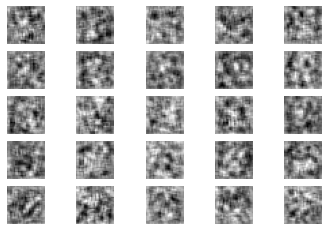

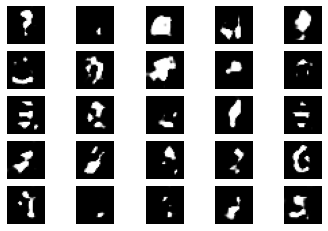

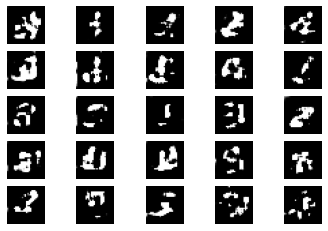

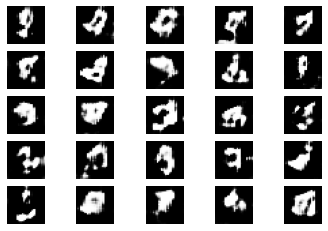

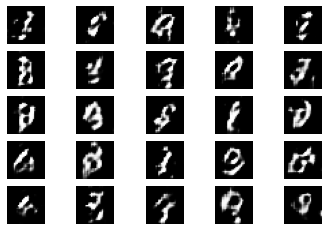

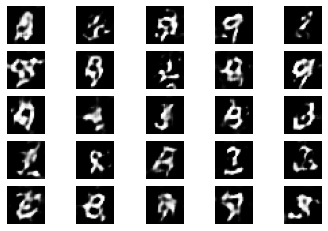

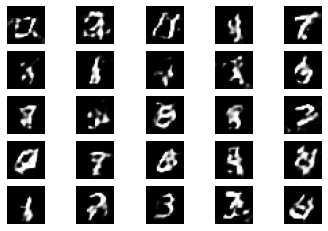

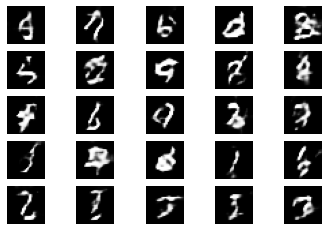

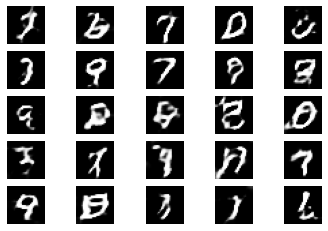

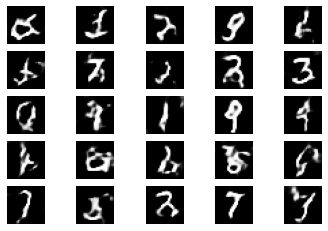

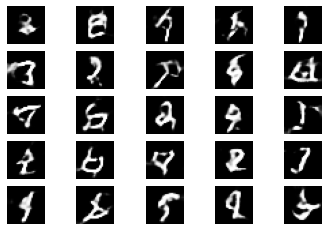

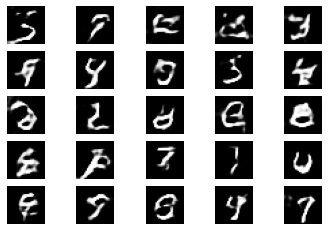

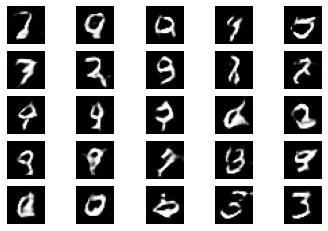

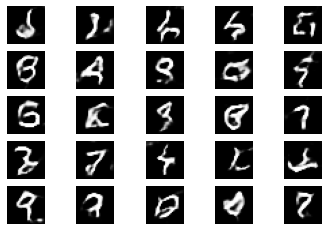

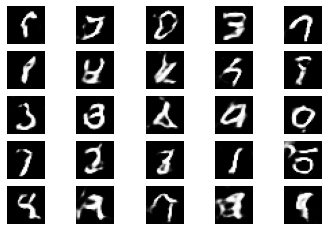

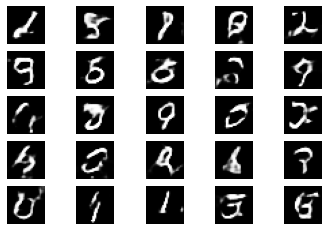

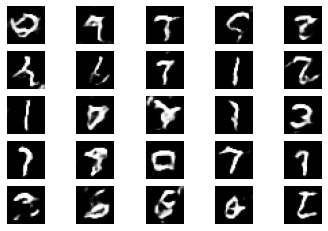

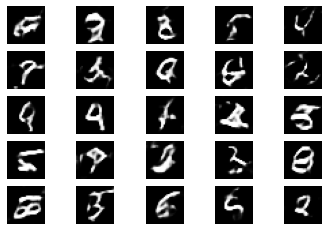

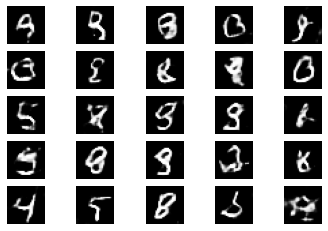

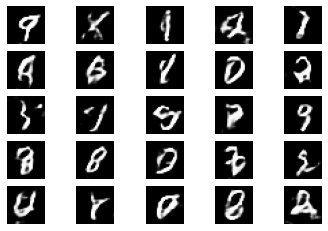

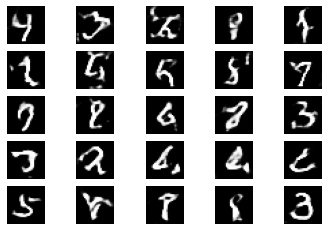

In [25]:
gan_train(4001,32,200)